# Introduction

Welcome to our tutorial presenting the usage of our package. Throughout this guide, we'll walk you through the following stages:

1. Create a Hetero Dirichlet 0.8 division of CIFAR-10.
2. Client and server FL initialization.
3. Launch training.
4. Visualize results.

# Package importation

In [2]:
import torchvision
from torchvision import datasets, transforms
import data_manipulation.Data_distribution as Data_distribution

from fedlab.utils.dataset import CIFAR10Partitioner
from fedlab.utils.functional import partition_report
import models.CIFAR10.CNN as CNN

import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import torch.nn as nn
import timeit
import pickle
import torch

import prints.result_plot as result_plot

# Creation of a non-iid division of CIFAR-10

We'll begin by demonstrating how to create a Hetero Dirichlet 0.8 division of the CIFAR-10 dataset using the FedLab framework

In [3]:
# Define a transformation to normalize CIFAR-10 images
trans_cifar = transforms.Compose([
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize pixel values to range [-1, 1]
])

# CIFAR-10 training dataset
dataset_train = datasets.CIFAR10('data/cifar10/', train=True, download=True, transform=trans_cifar)

# CIFAR-10 testing dataset
dataset_test = datasets.CIFAR10('data/cifar10/', train=False, download=True, transform=trans_cifar)

# Display dataset information
print("Number of training samples: ", len(dataset_train))
print("Size of an image: ", list(dataset_train[0][0].shape))


Files already downloaded and verified
Files already downloaded and verified
Number of training samples:  50000
Size of an image:  [3, 32, 32]


In [4]:
# Create the data division

db = Data_distribution.Data_distribution(dataset_train, 100)

num_clients = 100
seed = 40
num_classes = 10

client_index_non_iid_100_fedlab = CIFAR10Partitioner(dataset_train.targets, 
                                100,
                                balance=None, 
                                partition="dirichlet",
                                dir_alpha=0.5,
                                seed=seed)

# generate partition report
csv_file = "./partition-reports/Cifar_heterdirichlet_08.csv"
partition_report(dataset_train.targets, client_index_non_iid_100_fedlab.client_dict, 
                 class_num=num_classes, 
                 verbose=False, file=csv_file)

col_names = [f"class{i}" for i in range(num_classes)]

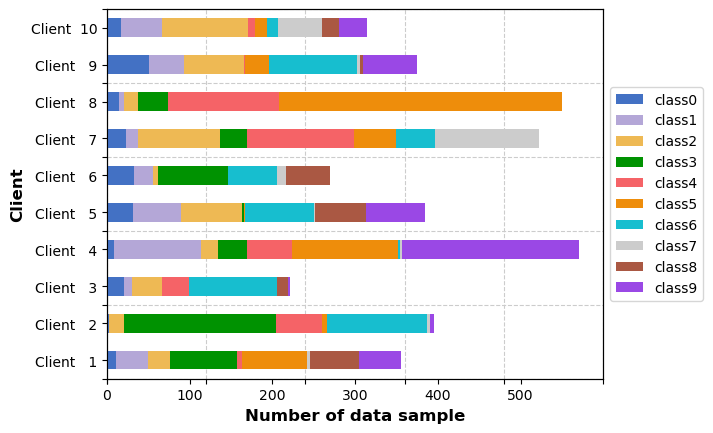

In [5]:
# Print the data distribution

client_index_non_iid_100_fedlab_df = pd.read_csv(csv_file,header=1)
client_index_non_iid_100_fedlab_df = client_index_non_iid_100_fedlab_df.set_index('client')
for col in col_names:
    client_index_non_iid_100_fedlab_df[col] = (client_index_non_iid_100_fedlab_df[col] * client_index_non_iid_100_fedlab_df['Amount']).astype(int)
    
# Create a new figure and axis
fig, ax = plt.subplots()

# Plot the distribution for the specific clients on the new axis
colors = ['#4371C4', '#B4A7D7', '#EEB954', '#009201','#F56367' , '#ee8d0b', '#17BECF','#CCCCCC', '#AA5843','#9a48e5']

#specific_client_data.plot.barh(stacked=True, ax=ax, color=colors)

client_index_non_iid_100_fedlab_df[col_names][1:11].plot.barh(stacked=True, ax=ax, color=colors)  

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Set x-label and y-label
ax.set_xlabel('Number of data sample', fontsize=12, fontweight='semibold')
ax.set_ylabel('Client', fontsize=12, fontweight='semibold')


# Add a transparent axis for grid lines on the same figure
ax_grid = ax.inset_axes([0, 0, 1, 1], transform=ax.transAxes, zorder=-1)
ax_grid.grid(True, color='#CCCCCC', linestyle='--')

ax_grid.set_xticklabels([])
ax_grid.set_yticklabels([])

# Save the figure with the plot and grid lines
plt.savefig(f"images/Cifar_10_selected.pdf", dpi=400, bbox_inches='tight')

plt.show()  # Show the plot

In [6]:
# Structure the non-iid division
list_label = []
for x in np.array(client_index_non_iid_100_fedlab_df[col_names]):
    list_label.append(np.where(x > 0)[0])
    
dict_users = db.division_noniid_fedlab(client_index_non_iid_100_fedlab.client_dict.values(), list_label)

100%|██████████| 100/100 [00:05<00:00, 18.23it/s]


In [7]:
# Save the non-idd data division
with open('data_division/CIFAR10/CIFAR10_dict_hetero_dirichlet08.pkl', 'wb') as handle:
    pickle.dump(dict_users, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Client and server FL initialization 

In [8]:
# Read clients' information from stored files

# Load the dictionary containing client data from a pickle file
with open('data_division/CIFAR10/CIFAR10_dict_hetero_dirichlet08.pkl', 'rb') as f:
    Dict_users = pickle.load(f)

# Load lists containing clients' names, cores, frequencies, and bandwidths from respective pickle files
with open("clients_info/CIFAR10/names_list.pkl", "rb") as file:
    name_list = pickle.load(file)

with open("clients_info/CIFAR10/cores_list.pkl", "rb") as file:
    cores_list = pickle.load(file)

with open("clients_info/CIFAR10/frequency_list.pkl", "rb") as file:
    frequency_list = pickle.load(file)

with open("clients_info/CIFAR10/bandwidth_list.pkl", "rb") as file:
    bandwidth_list = pickle.load(file)

# Calculate the number of samples for each client
number_samples = []
for key in Dict_users.keys():
    number_samples.append(len(Dict_users[key]))

# Combine clients' information into a list
clients_info = list(zip(name_list, number_samples, cores_list, frequency_list, bandwidth_list))


In [11]:
# Load the pre-trained model for CIFAR10 from a saved file
#import serverFL.Server_FLASHRL as Server_FLASHRL
import AdaptFedCS_1.Server_AdaptFedCS as Server_AdaptFedCS


model_CIFAR10 = torch.load("models_saved/CIFAR10/CNNmodel.pt")

# Initialize the FL server with specific parameters
Serveur_AdaptFedCS = Server_AdaptFedCS.Server_AdaptFedCS(
    num_clients=100,  # Number of clients participating in Federated Learning
    global_model=model_CIFAR10,  # Global model
    dict_clients=Dict_users,  # Dictionary containing clients data
    loss_fct=torch.nn.CrossEntropyLoss(),  # Loss function for training
    B=50,  # Local batch size for training on each client
    dataset_test=dataset_test,  # Testing dataset for evaluation
    learning_rate=0.01,  # Learning rate for training
    momentum=0.9,  # Momentum value for optimization
    clients_info=clients_info  # Information about clients (names, num_samples, cores, etc.)
)

# FL Training

In [ ]:
# Perform Federated Learning training on the initialized server
# Initiate the Federated Learning training process on the server
results = Serveur_AdaptFedCS.global_train(
    comms_round=100,  # Number of communication rounds for training
    C=0.1,  # Fraction of clients selected to participate in each training round
    E=5,  # Number of local epochs for each client's training
    mu=0,  # FedProx hyperparameter (by default = 0)
    lamb=0.6,  # Past contribution factor
    rep_init=1 / 100,  # Initial reputation value)
    batch_size=50,  # Batch size used in each local training iteration
    verbose_test=1,  # Verbosity level for test results (e.g., showing test accuracy)
    verbos=0 # Verbosity level for training process (e.g., printing progress)
)


In [13]:
#calculate the energu consumption of AdaptFedCS
hidden_layer = 16

input_layer = 5 * 100

energy_DQN_light = (input_layer * hidden_layer + 1) / 4900

hidden_layer = 512

input_layer = 105 * 100

energy_DQN= (input_layer * hidden_layer + 1) / 4900

print(energy_DQN_light, energy_DQN)

1.6328571428571428 1097.1430612244899


# Results

In [14]:
# Initialize an object of the plot class to visualize results
print_result = result_plot.result_plot()

In [ ]:
#print(results)
print("Accuracy",np.array(results['Accuracy']))
print("Loss",np.array(results['Loss']))
#print(results['Rewards'])
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(results['Accuracy'])

In [74]:
a= np.sort(results['Rewards'])
print("reward DDQL",a[1,:])

reward DDQL [-0.1819359  -0.16985226 -0.14405068 -0.01206317  0.00280241  0.01465527
  0.02059022  0.02490611  0.02515743  0.07104534]


In [86]:
print('acc', np.array(print_result.assendante_list(results['Accuracy'])))

acc [[ 0.1453      0.17389999  0.2023      0.2463      0.3008      0.30430001
   0.31189999  0.37189999  0.42089999  0.44659999  0.44659999]
 [ 0.          1.          2.          3.          4.          5.
   6.          7.         12.         16.         20.        ]]


In [76]:

# Obtain the cumulative latency values for plotting
latence_cum_AdaptFedCS = print_result.cummulative_list(results['Timeurounds'])
print("latency",latence_cum_AdaptFedCS)

latency [1.98557207247889, 3.8941346555749847, 5.847968741456648, 7.714697554677066, 9.756456978439878, 12.238198203542794, 14.643473527012375, 16.72250301700875, 18.91886534004543, 20.853868092552013, 23.005445247920754, 25.154170241477985, 27.709927588124035, 28.80808902684743, 30.86046289984761, 32.976722047561196, 35.08721193011114, 36.92756443099683, 38.04482976669201, 40.17069792946738]


In [ ]:
#print(results['Best_model_weights'])
param_size = 0
model = results['Best_model_weights']
for param in model:
    param_size +=param.nelement()*param.element_size()

model_size = param_size/(1024**2)
print(model_size)

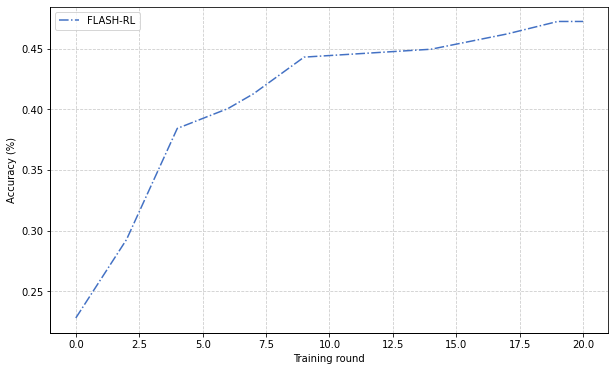

In [17]:
# Obtain the max accuracy values and corresponding training rounds for plotting
maxaccuracy_AdaptFedCs, traininground_fAdaptFedCS = print_result.assendante_list(results['Accuracy'])

# Plotting the max accuracy per training round

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add gridlines to the plot
ax.grid(True, color='#CCCCCC', linestyle='--')

# Plot the accuracy values per the training rounds for AdaptFedCS
ax.plot(traininground_AdaptFedCS, maxaccuracy_fAdaptFedCS, color="#4371C4", label="AdaptFedCS", linestyle='dashdot')

# Set the linewidth for the plot axes
ax.spines['bottom'].set_linewidth(1)  # x-axis
ax.spines['left'].set_linewidth(1)  # y-axis

# Add a legend and labels for better visualization understanding
ax.legend()
ax.set_xlabel("Training round")
ax.set_ylabel("Accuracy (%)")

# Display the plot
plt.show()

Please note that as the number of training rounds increases, the results tend to improve, enabling the RL agent to converge towards the optimal clients.

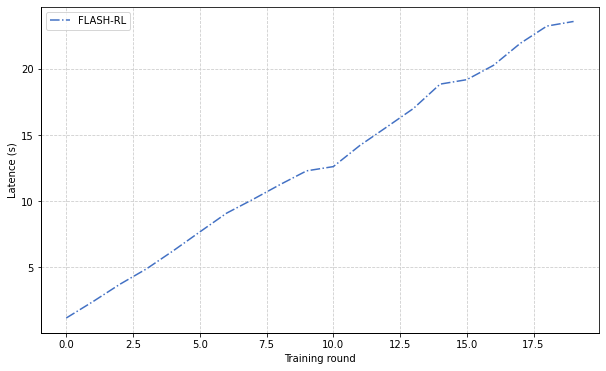

In [92]:
# Obtain the cumulative latency values for plotting
latence_cum_flasAdaptFedCShrl = print_result.cummulative_list(results['Timeurounds'])

# Plotting the end-to-end latency per training round

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Add gridlines to the plot
ax.grid(True, color='#CCCCCC', linestyle='--')

# Plot the cumulative latency values against the training rounds for AdaptFedCS
ax.plot(range(0, len(latence_cum_AdaptFedCS)), latence_cum_AdaptFedCS, color="#4371C4", label="AdaptFedCS", linestyle='dashdot')

# Set the linewidth for the plot axes
ax.spines['bottom'].set_linewidth(1)  # x-axis
ax.spines['left'].set_linewidth(1)  # y-axis

# Add a legend and labels for better visualization understanding
ax.legend()
ax.set_xlabel("Training round")
ax.set_ylabel("Latence (s)")

# Display the plot
plt.show()


Please note that as the number of training rounds increases, the results tend to improve, enabling the RL agent to converge towards the optimal clients.

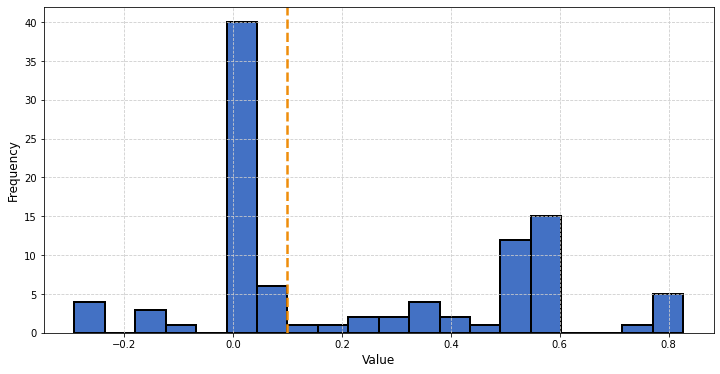

In [38]:
# Create a figure for the plot
plt.figure(figsize=(12, 6))

# Add gridlines to the plot
plt.grid(True, color='#CCCCCC', linestyle='--')

# Create a histogram of reputation values
plt.hist(results['Reputation'][10], bins=20, color="#4371C4", edgecolor='black', linewidth=2)

# Add a vertical line at x=0.1 to show the separation between -4 to 0 and 0.1 to 1
plt.axvline(x=0.1, color='#ee8d0b', linestyle='dashed', linewidth=2.5)

# Add labels and title
plt.xlabel('Value', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
# plt.title('Distribution of reputation values')

# Show the plot
plt.show()